# T022 - Ligand-based screening: Neural networks

Authors : 

- Ahmed Atta, CADD Seminar 2020, Charité/FU Berlin
- Sakshi Misra, internship (2020/21) at [Volkamer lab](https://volkamerlab.org), Charité
- Talia B. Kimber, 2020/21, [Volkamer lab](https://volkamerlab.org), Charité
- Andrea Volkamer, 2021, [Volkamer lab](https://volkamerlab.org), Charité

## Aim of this talktorial

In recent years, the use of neural networks in pharmaceutical research has shown promising results in addressing diverse problems in drug discovery. In this talktorial, we get familiar with the basic structure of artificial neural networks. We will learn how to build a simple two layer neural network and use it to predict the pIC50 values of unknown compounds against our target of interest (EGFR). Furthermore, we will select three *novel* compounds from the query data set that are predicted to be active against the EGFR kinase.

### Contents in *Theory*

- Biological background
    - EGFR kinase
    - Compound activity measures
    - Molecule encoding
- Neural networks
    - What is a neural network ?
    - Activation functions
    - Loss function
- How to train a neural network
    - Backpropagation
    - Gradient descent
    - Workflow to train a neural network using keras
- Advantages and applications of neural network

### Contents in *Practical*

- Collect and prepare the training data
    - Load data and visualize the dataframe
    - Data preparation: molecule encoding
- Train and evaluate a neural network
    - Define keras model
    - Choose the most appropriate batch sizes
    - Fit keras model
    - Prediction on test data
    - Evaluate keras model
    - Scatter plot between predicted and true pIC50 values
- Apply the network to external data
    - Prediction on unknown data
    - Select the top 3 compounds

### References

 - Theoretical background:
     - Articles    
         - Siddharth Sharma, "ACTIVATION FUNCTIONS IN NEURAL NETWORKS". [_International Journal of Engineering Applied Sciences and Technology, 2020_ **Vol. 4, Issue 12,** 310-316 (2020).](https://www.ijeast.com/papers/310-316,Tesma412,IJEAST.pdf)
         - Shun-ichi Amari, "Backpropagation and stochastic gradient descent method", [*ScienceDirect  **Volume 5, Issue 4-5**, 185-196*](https://doi.org/10.1016/0925-2312(93)90006-O)
         - Gisbert Schneider et al., "Artificial neural networks for computer-based molecular design", [*ScienceDirect **Volume 70, Issue 3**, 175-222*](https://doi.org/10.1016/S0079-6107(98)00026-1)
         - Filippo Amato et al., "Artificial neural networks in medical diagnosis", [*ScienceDirect  **Volume 11, Issue 2**, 47-58*](https://doi.org/10.2478/v10136-012-0031-x)         
     - Blogposts
          - Imad Dabbura, *Coding Neural Network — Forward Propagation and Backpropagtion*, [towardsdatascience, accessed April 1st, 2018](https://towardsdatascience.com/coding-neural-network-forward-propagation-and-backpropagtion-ccf8cf369f76).
          - Lavanya Shukla, *Designing Your Neural Networks*, [towardsdatascience, accessed Sep 23rd, 2019](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed)
          - Arthur Arnx, *First neural network for beginners explained (with code)*, [towardsdatascience, accessed Jan 13th, 2019](https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf) 
          - Varun Divakar, *Understanding Backpropagation*, [QuantInst, accessed Nov 19th, 2018](https://blog.quantinsti.com/backpropagation/) 
               
- Packages:
     - [rdkit](http://rdkit.org/): Greg Landrum, *RDKit Documentation*, [PDF](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf), Release on 2019.09.1.
     - [Keras](https://keras.io/): Book chapter: "An Introduction to Deep Learning and Keras" in [*Learn Keras for Deep Neural Networks* (2019), **page(s):1-16**](https://doi.org/10.1007/978-1-4842-4240-7).
     - [Sequential model](https://keras.io/api/models/sequential/) in keras
     - [Model training APIs](https://keras.io/api/models/model_training_apis/#model-training-apis)

## Theory

### Biological background

#### EGFR kinase

- [Epidermal growth factor receptor (EGFR)](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor) is a transmembrane protein/receptor present on the cell membrane. It is a member of the ErbB family of receptors. 
- EGFR plays an important role in controlling normal cell growth, apoptosis and other cellular functions. 
- It is activated by ligand binding to its extracellular domain, upon activation EGFR undergoes a transition from an inactive monomeric form to an active homodimers.
- The EGFR receptor is upregulated in various types of tumors or cancers, so an EGFR inhibition is a type of biological therapy that might stop cancer cell from growing.

#### Compound activity measures

- **IC50** is the half maximal inhibitory concentration of a drug which indicates how much of a drug is needed to inhibit a biological process by half. 
- **pIC50** is the negative log of the IC50 value. It is more easily interpretable than IC50 values and a common measure for potency of compounds (see [talktorial 001](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T001_query_chembl/talktorial.ipynb) for further details).

#### Molecule encoding

For machine learning algorithms, molecules need to be converted into a machine readable format, e.g. a list of features. In this notebook, molecular fingerprints are used. 

Molecular fingerprints represent or encode the chemical structures and molecular features in a bit string, where at each position "1" represents the presence and "0" represents the absence of a feature. One of the common fingerprints used are **M**olecular **ACC**ess **S**ystem fingerprints [(MACCS Keys)](https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#maccs) which are 166 bits structural key descriptors in which each bit is associated with a [SMARTS](https://docs.eyesopen.com/toolkits/python/oechemtk/glossary.html#term-smarts) pattern encoding a specific substructure (see [talktorial 004](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T004_compound_similarity/talktorial.ipynb) for further details).

### Neural networks

#### What is a neural network?

Neural networks, also known as artificial neural networks (ANNs) are a subset of machine learning algorithms. The structure and the name of the neural network is inspired by the human brain, mimicking the way that biological neurons transfer signals to one another.

<div>
<img src="images/basic_structure.png" width="500" align="center"/>
</div>

*Figure 1:* Figure shows the basic structure of an artificial neural network. It is taken from the blogpost: "*Designing Your Neural Networks*", Lavanya Shukla, [towardsdatascience](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed).

ANNs are comprised of three main layers as shown in the figure above: **Input layer**, **hidden layers** and **output layer**. Lets take a deeper look at each layer.

1. **Input neurons or input layer**
   - This layer represents the number of features which are used to make the predictions.
   - The input vector needs one input neuron per feature.
2. **Hidden layers and neurons per hidden layer**
    -  The optimal size of the hidden layer is usually between the size of the input and the size of the output layer. 
    - In general, using the same number of neurons for all hidden layers will suffice but for some datasets, having a large first layer and following it up with smaller layers will lead to a better performance as first layers can learn a lot of low-level features that can fed into the next subsequent layers which can learn higher order features.
3. **Output neurons or output layer**
    - The output layer contains the number of neurons which represents the number of predictions you want to make and the neuron with highest probability value determines the output.
    - **Regression**: For regressions tasks, this can be a value like predicting the price of a house or predicting stock prices.
    - **Classification**: For binary classification tasks, we have an output neuron per positive class which represents the probability of the positive class whereas for multi-class classification, we have an output neuron per class and we use a certain activation function on the output layer to ensure the final probabilities sum to 1.
  
  

**Neurons** are the basic units of a neural network, so lets look into the operations done by each neuron to understand the overall mechanism of a neural network.

<div>
<img src="images/neuron.png" width="500" align="center"/>
</div>

*Figure 2:* Operations done by a neuron. Figure is taken from the blogpost: "*First neural network for beginners explained (with code)*", Arthur Arnx, [towardsdatascience](https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf).


- First, the values from the previous layer's neurons are added up and sent to the current neuron. In the figure above, there are 3 inputs $(x1, x2, x3)$ coming to the neuron, meaning 3 neurons are connected to our current neuron. 
- Each connection (or channel) has been assigned to a numerical value known as **weight** $(w1, w2, w3)$. This weight determines the influence the input will have on the output. The inputs are multiplied by the corresponding weights and their sum is sent to the neurons in the hidden layer.
- Each of these neurons is associated with a numerical value called the **bias** which is then added to the input sum.
- Both weights and bias, commonly referred to as $w$ and $b$, are the learnable parameters which can be tuned while training the model to get a well performing model. The equation below summarises the operations done by our neuron. $Y$ is the value of the input sum of a neuron before the activation function is applied:

$$ Y = \sum (w1*x1 + w2*x2 + w3*x3) + bias $$

- After all those summations, the value is then passed through a threshold function called the **activation function**. The result of the activation function determines if the particular neuron will get activated or not. An activated neuron transmits data to the neuron of the next layer over the channels. In this manner, the data is propagated through the network which is known as **forward propagation**. There are many types of activation functions which we will discuss in detail in the next section.

#### Activation function

**What is an activation function?**

[Activation functions](https://en.wikipedia.org/wiki/Activation_function) are the mathematical equations that determine the output of a neural network. This function is applied to each neuron and it determines whether the neuron should be activated or not. 

The value of **Y** can be anything ranging from $-\infty$ to $+\infty$ . The neuron does not know the bounds of the value, so how do we decide whether the neuron should be activated or not? Here, the activation function helps normalizing the output of each neuron to a range between 0 and 1 or between -1 and 1 depending on the type of activation function used. The activation function simply works as a "gate" in between the input feeding the current neuron and its output going to the next layer as shown below, 

<div>
<img src="images/activation.png" width="500" align="center"/>
</div>

*Figure 3:* Figure shows the activation function applied on a neuron. It is taken from the blogpost: [7 Types of Neural Network Activation Functions: How to Choose?](https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/)

**Types of activation function**

There are many types of activation, we will discuss here only the ones which we will use in the practical section below. For more information see the supplementary section and references.

Most neural networks use non-linear activation functions as it makes it easier for the model to generalize or adapt to a variety of data and to differentiate between the output.

**Rectified Linear Unit (ReLU)** is one of the most commonly used activation functions. 

- It takes the form: $\boxed{f(x) = max\{ 0, x\}}$
- As shown below in the figure, [ReLu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) gives an output $x$, if $x$ is positive and $0$ otherwise. The range of ReLu is [0, inf) which is not bound. 
- One of the reasons of it being commonly used could be its sparsity in the activation. Imagine if we have a deep neural network with many neurons, using a sigmoid or tanh function will cause all the neurons to be activated, this is costly. But with ReLu, only few neurons will be activated and thereby making the activations sparse and efficient.
- The only issue is that when inputs approach to zero or negative, the gradient of the function becomes zero hence, the network cannot learn and perform backpropagation. 
- It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

<div>
<img src="images/relu.png" width="400" align="center"/>
</div>

*Figure 4:* Representation of a *ReLU* function. Figure by Sakshi Misra.


 
**Linear activation function** is an another type of activation function which we have used for the output layer. 

- A [linear activation function in keras](https://keras.io/api/layers/core_layers/dense/) takes the form: $\boxed{a(x) = x}$
- It is a straight line function where the activation is proportional to its input, which is the weighted sum from the neurons. 
- The most appropriate activation function for the output neuron(s) of a neural network used for regression problems is a linear activation.

#### Loss function 

In a neural network, we have an objective function i.e. to minimize the prediction error, so this objective function is often referred to as cost function or **loss function**. A loss function is one of the important components of training the neural networks. 

Keras and tensorflow have various inbuilt loss functions, we will be covering two of them here:
- The **Mean Squared Error (MSE)** is used for regression tasks, as the name suggests this loss is calculated by taking the mean of squared differences between actual (target) and predicted values. 
- The **Mean Absolute Error (MAE)** is also used for regression tasks, the loss is calculated by taking the mean of the absolute values of the individual prediction errors, where the prediction error is the difference between the actual and predicted values.

The choice of loss function is directly related to the activation function used in the output layer of the neural network. For example, in our case we have to predict the pIC50 value of drug molecules so it is a regression task. We can use a linear activation function in the output layer and the mean squared error (mse) as our loss function.


You can refer to the blogpost: [Loss and Loss Functions for Training Deep Learning Neural Networks](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/) for more details.

### How to train a neural network ?

When we perform [forward propagation](https://en.wikipedia.org/wiki/Feedforward_neural_network), we initialize our network with randomly assigned weights. Obviously, it will not give very good results, so how does the network figures this out? 

During the training process, along with the input also the (actual) output in fed to our network. The predicted output is compared against the actual output to realize the error in prediction, the magnitude of the error indicates how wrong we are. This error is computed using the loss function which we want to minimize during training. This can be done by calculating the gradient by back propagating through the network and adjusting the weights such that the network can predict the output more reliably. 

There are major two algorithms which help in training the neural network model:

- [Back propagation](https://en.wikipedia.org/wiki/Backpropagation): gradient computation  
- [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent#:~:text=Gradient%20descent%20is%20a%20first,the%20direction%20of%20steepest%20descent.): optimization method to minimize the loss or cost function

#### Back propagation

Back propagation is an efficient method of calculating the derivatives or gradient. This algorithm trains a neural network through a method called chain rule. In simple terms, after each forward pass through a network, backpropagation performs a backward pass while adjusting the model’s parameters (weights and biases) which aims to minimize the cost function.

#### Gradient descent 

**Gradient** is the vector which points to the direction of the steepest increase of the function. Since, we want to minimize our function, we will take a step in the opposite direction of the gradient. Generally, we want to control how big of a step we make. This is achieved by choosing the most important hyper parameter which is called [learning rate](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b). Mostly people choose the learning rate by trying out a bunch of numbers and using the one that works best. 

In our neural network, we have weights which values we want to improve. If we compute the gradient of the loss function w.r.t. to our weights and take small steps in the opposite direction of the gradient, our loss will gradually decrease until it converges to some local minima, this algorithm is called **gradient descent**. So in short, it is the process of descending through the gradient i.e. adjusting the parameters of the model to minimize the loss function and achieve our goal, which is to predict values close to the original values. There are many types of gradient descent methods or say batch sizes which refers to the number of samples that will be propagated through the network to train it. 

We can train the model to optimize the loss function using:
- only a *single sample* from our dataset: **Stochastic Gradient Descent (SGD)**
- the the *whole dataset*: **Batch Gradient Descent**
- *b samples* where $b<m$ (m be the number of training example) are processed per iteration: **Mini-Batch Gradient Descent** 
    
    The latter is a type of gradient descent which works faster than both batch gradient descent and stochastic gradient descent. Even if the number of training examples is large, it is processed in batches of $b$ training examples in one go. Thus, it works for larger training examples and with lesser number of iterations.

#### Workflow to train a neural network using keras

Let us first understand the basic workflow of how [keras](https://keras.io/getting_started/) helps in the process of deep learning. The goal is to train a neural network model with the training dataset and predict the pIC50 value for the molecules from a test dataset which it has not seen before.
 
- **Prepare data** − Foremost for any machine learning algorithm, we process, filter and select only the required information from the data. Then, the data is split into training and test data sets. The test data will be used to evaluate the prediction of the algorithm / model and to cross check the efficiency of the learning process.

 
- **Define the model** - In keras, every ANN is represented by keras [models](https://keras.io/api/models/model/#model-class). Keras provides a way to create a model which is called [sequential model](https://keras.io/api/models/sequential/). The layers are arranged sequentially where the data flows from one layer to another layer in the given order until the data finally reaches the output layer. Each layers in the ANN can be represented by a *keras layer* in keras. 


- **Compile the model** − The compilation is the final step in creating a model. Once the compilation is done, we can move on to the training phase. A **loss function** and an **optimizer** are required in the learning phase to define the error (deviation from the actual output) and to minimize it. In our example, we use the **mean square error** as a loss argument and the **adam** optimizer, which is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.

  To learn more about the various Adam versions of stochastic gradient descent see the blogpost: [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).


- **Fit the model** - The actual learning process will be done in this phase using the training data set. We can call [fit()](https://keras.io/api/models/model_training_apis/#fit-method) method which needs several parameters like **x**: input data, **y**: target data, batch size, epochs etc. **Epochs** means number of times the model is needed to be evaluated during the training process. For example one epoch means when an entire dataset is passed forward and backward through the neural network once.


- **Predict result for unknown data** − Keras provides a method, [predict](https://keras.io/api/models/model_training_apis/#predict-method) to make a prediction for new data points using the trained model.


- **Evaluate model** − We can evaluate the model by predicting the output for test data and cross-comparing the prediction with the actual result of the test data (label) by using the [evaluate](https://keras.io/api/models/model_training_apis/#evaluate-method) method provided by keras. Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data.

  **Scatter plots** are a common and simple approach to evaluate models which plots predicted vs. observed values (or vice versa) and compares slope and intercept parameters.

### Advantages and applications of neural network

**Advantages of a neural network** 

- **Organic learning**: Neural networks have the ability to learn by themselves by extracting the important features present in the input data. The outputs aren't limited entirely by inputs. Neural networks have the ability to generalize their inputs.
- **Non linear data processing**: They have the ability to learn and model non-linear and complex relationships. 
- **Fault tolerance**: They have the potential for high fault tolerance such that corruption of one or more cells of an ANN does not prevent it from generating output.

To learn more about advanatges and disadvantages of a neural network, please refer to the article: Maad M. Mijwel, "*Artificial Neural Networks Advantages and Disadvantages*", [research gate (2018)](https://www.researchgate.net/profile/Maad_Mijwil/publication/323665827_Artificial_Neural_Networks_Advantages_and_Disadvantages/links/5aa2c01faca272d448b5a23d/Artificial-Neural-Networks-Advantages-and-Disadvantages.pdf).

**Applications of neural networks**

There are various applications of neural networks in computer aided drug design  such as:

- Drug design and discovery
- Biomarker identification and/or classification
- Various types of cancer detection
- Pattern recognition etc.

Please refer to the article: Cheirdaris D.G. (2020), "*Artificial Neural Networks in Computer-Aided Drug Design: An Overview of Recent Advances*",  [GeNeDis 2018. Advances in Experimental Medicine and Biology, **vol 1194**. Springer](https://link.springer.com/chapter/10.1007/978-3-030-32622-7_10) for more details.

## Practical

The first step is to import all the necessary libraries and to define the functions and classes we intend to use in this notebook.

In [1]:
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# Silence some expected warnings
filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-h92x_e9s because the default path (/home/andrea/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Collect and prepare the training data

###  Load data and visualize the dataframe

Let's load our data which is a subset of ChEMBL dataset avilable for EGFR and visualize the dataframe. The important columns in the dataframe are:
- CHEMBL-ID
- SMILES string of the corresponding compound
- Measured affinity: pIC50

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

df = pd.read_csv(DATA/'CHEMBL25_activities_EGFR.csv',
                 index_col = 0)  # NBVAL_CHECK_OUTPUT

df=df.reset_index(drop=True)

In [3]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

# Look at head
df.head() # NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3906, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chembl_id         3906 non-null   object 
 1   IC50              3906 non-null   float64
 2   units             3906 non-null   object 
 3   canonical_smiles  3906 non-null   object 
 4   pIC50             3906 non-null   float64
dtypes: float64(2), object(3)
memory usage: 152.7+ KB


,chembl_id,IC50,units,canonical_smiles,pIC50
0,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,CHEMBL504034,40.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,CHEMBL158797,43000.0,nM,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


In [4]:
# Keep the necessary columns
chembl_df = df[["canonical_smiles", "pIC50"]]
chembl_df.head()  # NBVAL_CHECK_OUTPUT

,canonical_smiles,pIC50
0,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


#### Data Preparation: Molecule encoding
First, we have to convert the SMILES string to numerical data so that we can perform machine learning algorithm on it and we can use already defined function `smiles_to_fp` from Talktorial **T007** which generate fingerprints from SMILES. 
We will use the default encoding, i.e. MACCS keys with 166 bits (see [talktorial 007](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T007_compound_activity_machine_learning/talktorial.ipynb) for more info on molecular encodings)

In [5]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}."
              " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

Convert all SMILES strings to MACCS fingerprints

In [6]:
chembl_df['fingerprints_df'] = chembl_df['canonical_smiles'].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head(3)  # NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3906, 3)


,canonical_smiles,pIC50,fingerprints_df
0,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Next, we define the **features** and the **target data** which will be used to train the model. In our case, features are the bit vectors and the target values are the pIC50 values of the molecules which we want to predict.

We can then use `train_test_split` from scikit-learn library to split the data into 70% training and 30% test data.

In [7]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
             chembl_df['fingerprints_df'], 
             chembl_df[['pIC50']], test_size=0.3, random_state=42)
# NBVAL_CHECK_OUTPUT
# Print the shape of training and testing data
print("Shape of training data : ", x_train.shape)
print("Shape of test data : ", x_test.shape)

Shape of training data :  (2734,)
Shape of test data :  (1172,)


### Train and evaluate a neural network

#### Define keras model

A keras model is defined by specifying the number of neurons in the layer and the activation function as arguments. 
For our purpose, we define a model with *two hidden layers*. As activation function, we use [relu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) in the hidden layers and [linear](https://keras.io/api/layers/core_layers/dense/) in the output layer to predict the pIC50 values.
Finally, we compiled the model by using *mean squared error* as a loss argument and *adam* as an optimizer.

In [8]:
def NN_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using relu as activation function in two hidden layers
    and linear activation in the output layer

    Parameters
    ----------
    hidden1 : Int
         Number of neuons in first hidden layer

    hidden2: Int
         Number of neuons in second hidden layer
    
    Returns
    --------
    model
        Fully connected neural network model with two hidden layers
    """

    model = Sequential()
    # first hidden layer
    model.add(Dense(hidden1, activation='relu', name="layer1"))
    # second hidden layer
    model.add(Dense(hidden2, activation='relu', name="layer2"))
    # output layer
    model.add(Dense(1, activation='linear', name="layer3"))
    
    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['mse', 'mae'])
    return model

#### Choose the most appropriate batch size

As an example, we pass different mini-batches and plot the respective losses.

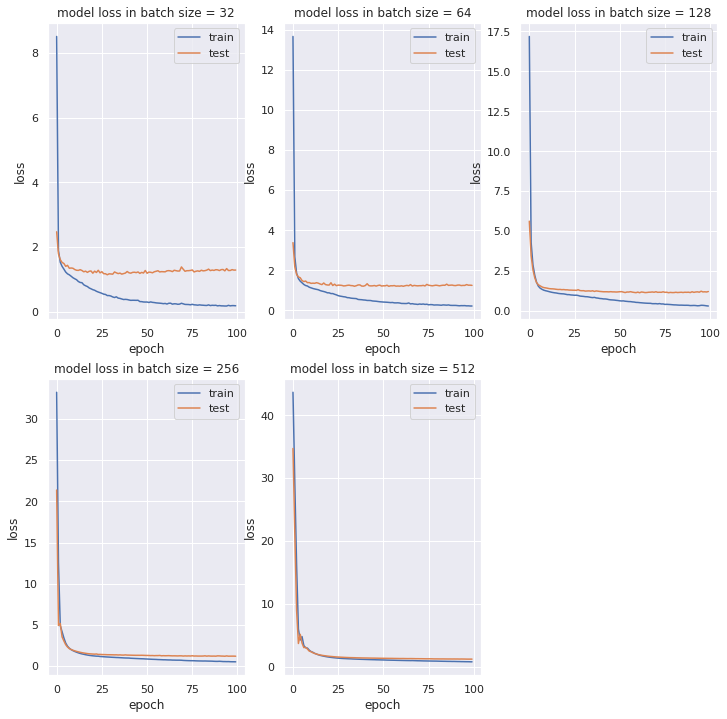

In [9]:
# trying different batch sizes
batch_sizes = [32, 64, 128, 256, 512]

# size of figure
fig = plt.figure(figsize=(12, 12))
sns.set(color_codes=True)
for index in range(len(batch_sizes)):
    fig.add_subplot(2, 3, index+1)
    model = NN_model(64, 32)
    
  # fit model on x_train and y_train data
    history = model.fit(np.array(list((x_train))).astype(float), y_train.values,
                        batch_size=batch_sizes[index],
                        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
                        verbose=0, epochs=100)
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f"model loss in batch size = {str(batch_sizes[index])}")
plt.show()  # NBVAL_CHECK_OUTPUT

#### Fit keras model

[ModelCheckpoint callback](https://keras.io/api/callbacks/) is used to save the best model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

Now, we can train the model by passing several arguments like features, target data, epochs and batch size. We specified batch size to be 512 because as seen from the figure above, it has the lowest loss (compared to the other four examples) and specified epochs to be 100. 

In [10]:
# save the model
filepath = DATA/"best_weights.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0,
                             save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

# fit the model
model.fit(np.array(list((x_train))).astype(float), y_train.values, 
          epochs=100, batch_size=512,
          callbacks=callbacks_list, verbose=0)

#### Evaluate keras model

The [evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) method is used to check the performance of our model. It will report the **loss**, **mse** and **mae** values.

In [11]:
# Evalute the model 
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse: {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")  # NBVAL_CHECK_OUTPUT

Evaluate the model on the test data
 loss: 1.21
 mse: 1.21
 mae: 0.84


**Predict keras model on test data**

Prediction is the final step and our expected outcome of the model generation. Keras provides a method, [predict()](https://keras.io/api/models/model_training_apis/#predict-method) to get the prediction of the trained model. We can use  this method to predict the pIC50 values on test data. 

In [12]:
# Predict pIC50 values on x_test data 
y_pred = model.predict(np.array(list((x_test))))
y_pred  # NBVAL_CHECK_OUTPUT

array([[5.876576 ],
       [9.337025 ],
       [6.401411 ],
       ...,
       [5.8744245],
       [7.1122155],
       [4.457241 ]], dtype=float32)

#### Scatter plot between predicted and true pIC50 values

[Scatter_plots](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.scatter.html) are used to plot the predicted vs. true values, which would ideally follow a straight line. 

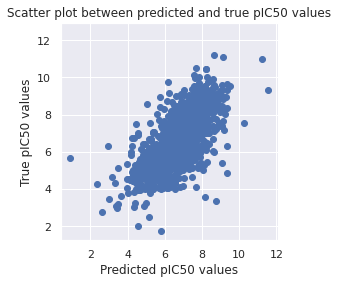

In [13]:
# Scatter plot 
plt.scatter(y_pred, y_test)
plt.axis('square')
plt.xlabel('Predicted pIC50 values')
plt.ylabel('True pIC50 values')
plt.title('Scatter plot between predicted and true pIC50 values')
plt.show()  # NBVAL_CHECK_OUTPUT

As we can see, there is a positive linear relation between the points, but our predictions are far from being perfect, meaning this model might not be the best fit. 

### Apply the model to external data

#### Prediction on unknown data

Now, we can use our trained model and predict the pIC50 values on unknown data (also deposited in this repo).

In [14]:
test_df = pd.read_csv(DATA/'test.csv',
                      index_col = 0)
test_df = test_df.reset_index(drop=True)
test_df.head()  # NBVAL_CHECK_OUTPUT

,canonical_smiles
0,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1
1,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1
2,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1
3,O=C(/C=C/CN1CC[NH+](C)CC1)N1Cc2sc3ncnc(N[C@H](...
4,S(=O)(=O)(NC(=O)Cn1c(C)ncc1[N+](=O)[O-])c1ccc(...


We used the same `smiles_to_fp` function and convert the SMILES strings in *unknown* data as well into MACCS fingerprints.

In [15]:
# convert all SMILES strings to MACCS fingerprints
test_df['fingerprints_df'] = test_df['canonical_smiles'].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", test_df.shape)
test_df.head(3)  # NBVAL_CHECK_OUTPUT

Shape of dataframe :  (60, 2)


,canonical_smiles,fingerprints_df
0,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Note**: For reproducibility, you can save the model by using [save_model()](https://keras.io/api/models/model_saving_apis/#savemodel-function) function and load the model again by using [load_model()](https://keras.io/api/models/model_saving_apis/#loadmodel-function) function. By doing this, it will produce the same results at the end of the prediction.

In [16]:
# prediction on test data
model = load_model(DATA/"ANN_model.hdf5")
pred = model.predict(np.array(list((test_df['fingerprints_df']))).astype(float), callbacks=callbacks_list)

predicted_pIC50 = pd.DataFrame(pred, columns=['Predicted pIC50 values'])
predicted_pIC50_df = test_df.join(predicted_pIC50)

predicted_pIC50_df.head(3)  # NBVAL_CHECK_OUTPUT

,canonical_smiles,fingerprints_df,Predicted pIC50 values
0,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.779419
1,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.483406
2,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.343009


In [17]:
# save predicted csv file in the data folder
predicted_pIC50_df.to_csv(DATA/'predicted_pIC50_df.csv')

#### Select the top 3 compounds

Now, we can exemplary select the 3 compound with the highest predicted pIC50 values that could be further investigated for the potential to be used as epidermal growth factor receptor inhibitor.

In [18]:
# select top 3 drugs
predicted_pIC50_df = pd.read_csv(DATA/'predicted_pIC50_df.csv')
top3_drug = predicted_pIC50_df.nlargest(3, 'Predicted pIC50 values')
top3_drug  # NBVAL_CHECK_OUTPUT

,Unnamed: 0,canonical_smiles,fingerprints_df,Predicted pIC50 values
9,9,Brc1cc(Nc2ncnc3nc(NC)ccc23)ccc1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,8.481803
53,53,c1cc(ccc1Nc2c(c(nc[nH+]2)NCCCn3cc[nH+]c3)N)I,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,8.144416
18,18,Clc1c(F)ccc(NC=2N=CNC=3C=2C=C(OCCCCC=C=C)C(=O)...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,8.120270


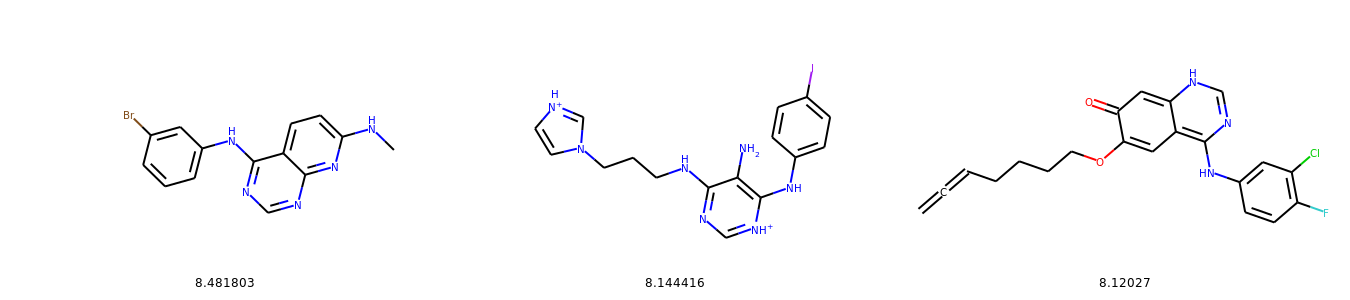

In [19]:
# draw the drug molecules
highest_pIC50 = predicted_pIC50_df['canonical_smiles'][[9, 53, 18]]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pIC50]
pIC50_EGFR = top3_drug['Predicted pIC50 values'].astype(str).tolist()

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pIC50_EGFR)  # NBVAL_CHECK_OUTPUT

## Discussion





From above we can see that there are some similarities between all three molecules such as containing an aniline and pyrimidine group, as well as several aromatic carbon rings.

<div>
<img src="images/drugs.png" width="800" align="center"/>
</div>

*Figure 5:* Representing similarities between selected top 3 drug molecules.

Note that the *unknown* sample data was taken from ChEMBL as well, so we can double check if our predictions did indeed make sense.
E.g. the first compound, with SMILES ``Brc1cc(Nc2ncnc3nc(NC)ccc23)ccc1`` and predicted pIC50 value of 8.48, indeed has a high tested affinity against EGFR, i.e. pIC50 of 7.28, for more details see entry [CHEMBL298637](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL298637/).

This predictive modeling is **advantageous** because it is not time consuming and cheap as compared to laboratory experiments. It can give a general overview about what kind of molecules could be investigated further as potential EGFR inhibitors. 

Also this model has some **disadvantages** like it highly depends upon chemical space and completeness of the training data, the parameter tuning as well as variable initialization which might affect the final results. This also does not provide the information about the side effect of the compounds and their toxicity on normal cells.

## Quiz

- What other hyperparameters can be tuned to get better performance result?
- What other activation functions and metrices can be used while defining the model?
- Can you think of any other visualization method to visualize the prediction and observed values?

-------
## Supplementary section

If you are interested in more details, please keep reading this section. Here, we have defined other activation and forward propagation functions to get a better understanding of the underlying concepts.

**Activation Functions**

Let us discuss some other activation functions and define them using python.

1) **Sigmoid function (σ)**: It takes the form: $$\boxed{f(x)=\frac{1}{1+e^{−x}}}$$ 

   -  The sigmoid curve looks like a *S*-shaped curve as shown in the figure below. 
   - It has a "smooth gradient" which prevents jumps in the output values and it bounds the output values between 0 and 1.
   - It is recommended to be used only on the output layer so that the output can be interpreted as probabilities. 
   - If you notice in the figure below, for $x$ values between -2.5 to 2.5, $y$ values are very steep, so any small change in values of $x$ in that region will cause value of $y$ to change significantly. It tends to bring the activations to either side of the curve.
   - Another advantage of this activation function is that the output lies in range (0,1) compared to (-inf, inf) of linear function.
   - But it has a major drawback, for very high or very low values of $x$, there is almost no change in y values or the prediction, causing a [**vanishing gradient**](https://towardsdatascience.com/the-vanishing-exploding-gradient-problem-in-deep-neural-networks-191358470c11) problem. This can cause the network to learn slowly or refuses to learn further. 
     
<div>
<img src="images/sigmoid.png" width="400" align="center"/>
</div>

*Figure 6:* Representation of a "sigmoid" function. Figure by Sakshi Misra.

2) **Hyperbolic Tangent function or TanH**:  It takes the form: $$\boxed{f(x)= tanh(x) = \frac{2}{1+e^{-2x}}−1}$$ it looks very similar to the sigmoid function, it can also be written as $$\boxed{tanh(x)= \text{2 sigmoid (2x)}-1}$$

   - It has the same characteristics as a sigmoid function like being non-linear in nature and the output is bound between -1 and 1. But it has deeper [derivatives](https://en.wikipedia.org/wiki/Derivative) which means it has stronger gradient than sigmoid as shown in the figure below. Deciding between sigmoid and tanh depends upon your requirement of gradient strength.
   - The disadvantage that it shares with sigmoid function is that the it also has a vanishing gradient problem.

<div>
<img src="images/tanh.png" width="400" align="center"/>
</div>

*Figure 7:* Representation of a "tanh" function. Figure by Sakshi Misra

3) **Leaky Rectified Linear Unit**: ReLu takes the form: $$\boxed{f(x)= \max\{ α ∗ x,x\}}$$

   - This is the variation of ReLU which has a small positive slope in the negative area.
   - The range of the Leaky ReLU is (-infinity to infinity).
   - It overcomes the zero gradient issue from ReLU and assigns α which is a small value for $x≤0$.

<div>
<img src="images/leaky.png" width="400" align="center"/>
</div>

*Figure 8:* Representation of a "Leaky ReLU" function. Figure by Sakshi Misra


Now, which activation function do we choose? Depending on the type of problem you are trying to solve, you can choose an activation function which will approximate the function faster and lead to faster raining process. There are other activation functions too, but the general idea remains the same. Please refer an article by H. N. Mhaskar, [How to Choose an Activation Function](https://papers.nips.cc/paper/1993/file/51ef186e18dc00c2d31982567235c559-Paper.pdf), for more details.

Now, we define the above discussed activation functions in python and plot them.

In [20]:
# Define activation functions that can be used in forward propagation
def sigmoid(input_array):
    """
    Computes the sigmoid of the input element-wise.

    Parameters
    ----------
    input_array : array
             Input values.

    Returns
    -------
    activation_function : array
             Post activation output.
    input_array : array
             Input values.
    """
    activation_function = 1 / (1 + np.exp(-input_array))

    return activation_function, input_array


def tanh(x):
    """
    Computes the hyperbolic tagent of the input element-wise.

    Parameters
    ----------
    input_array : array
             Input values.

    Returns
    -------
    activation_function : array
             Post activation output.
    input_array : array
             Input values.
    """
    activation_function = np.tanh(input_array)

    return activation_function, input_array


def relu(input_array):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Parameters
    ----------
    input_array : array
             Input values.
    Returns
    -------
    activation_function : array
             Post activation output.
    input_array : array
             Input values.
    """
    activation_function = np.maximum(0, input_array)

    return activation_function, input_array


def leaky_relu(input_array):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Parameters
    ----------
    input_array : array
             Input values.

    Returns
    -------
    activation_function : array
             Post activation output.
    input_array : array
             Input values.
    """
    activation_function = np.maximum(0.1 * input_array, input_array)

    return activation_function, input_array

We can also plot all the activation function using `matplotlib.plt` library as shown below.

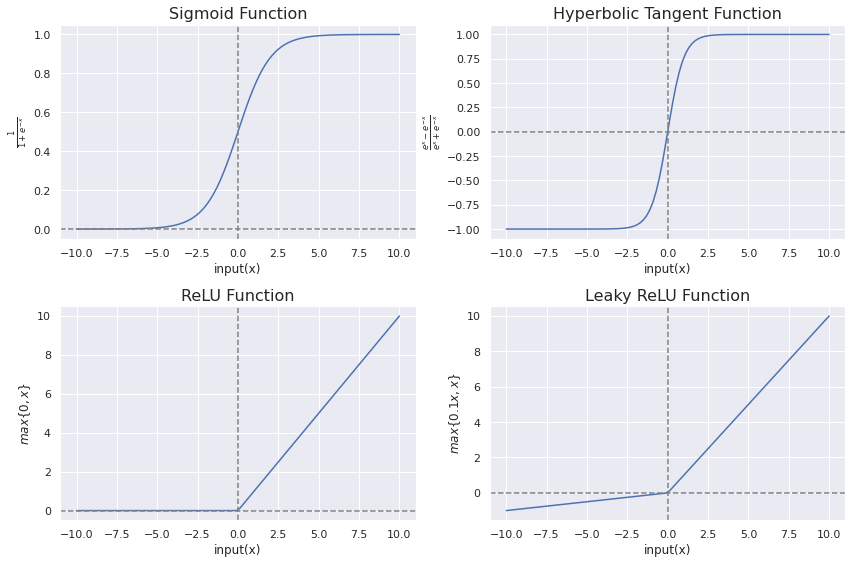

In [21]:
# Plot the four activation functions
input_array = np.linspace(-10, 10, 100)

# Computes post-activation outputs
activation_sigmoid, input_array = sigmoid(input_array)
activation_tanh, input_array = tanh(input_array)
activation_relu, input_array = relu(input_array)
activation_leaky_relu, input_array = leaky_relu(input_array)

# Plot sigmoid function
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(input_array, activation_sigmoid, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$\frac{1}{1 + e^{-x}}$")
plt.title("Sigmoid Function", fontsize=16)

# Plot tanh function
plt.subplot(2, 2, 2)
plt.plot(input_array, activation_tanh, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$\frac{e^x - e^{-x}}{e^x + e^{-x}}$")
plt.title("Hyperbolic Tangent Function", fontsize=16)

# plot relu function
plt.subplot(2, 2, 3)
plt.plot(input_array, activation_relu, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$max\{0, x\}$")
plt.title("ReLU Function", fontsize=16)

# plot leaky relu function
plt.subplot(2, 2, 4)
plt.plot(input_array, activation_leaky_relu, 'b')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("input(x)")
plt.ylabel(r"$max\{0.1x, x\}$")
plt.title("Leaky ReLU Function", fontsize=16)
plt.tight_layout()

**Forward Propagation**

Now, we will define forward propagation functions using classes, to better understand the forward propagation concept better.

First, we define a class named `Layer_Dense`. It has two properties, ``weights`` and ``biases``. We randomly assign their values and define a function named `forward_pass` which calculates the *dot product* of the input values and weights and adds them to the bias values. 
Since we know that the activation function is applied on every neuron, we create another class named `Activation_Function` using `ReLU` as an example. 

After defining classes and their attributes, we create an object from both classes and call the functions on our dataset. We can then print the output values which are the predicted pIC50 values.

**Note:** The predicted values will differ in every run because the weights are randomly assigned.  

In [22]:
# create forward pass function with one hidden layer
class Layer_Dense:
    """
    A class to represent a neural network
    
    '''
    Attributes
    ----------
    n_inputs : int
        Number of neurons in input layer
    n_neurons : int
        Number of neurons in hidden layer

    Method
    ------
    forward_pass(inputs):
        Computes the forward pass of a neural network.
    """

    def __init__(self, n_inputs, n_neurons):
        """
        Constructs all the necessary attributes.

        Parameters
        ----------
        n_inputs : int
            Number of neurons in input layer
        n_neurons : int
            Number of neurons in hidden layer

        """
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward_pass(self, inputs):
        """
        Compute forward pass.

        Parameters
        ----------
        input : int
            Input neurons.

        Returns
        -------
        None
        
        """
        self.output = np.dot(inputs, self.weights) + self.biases


class Activation_Function:
    """
    A class to represent an activation function

    Method
    ------
    ReLU(inputs):
        Apply the ReLU activation function.
    """
    def ReLU(self, inputs):
        """
        Apply the activation function to the neurons.

        Parameters
        ----------
        input : int
            Input neurons.

        Returns
        -------
        None
        
        """
        self.output = np.maximum(0, inputs)


        
# object
layer1 = Layer_Dense(167, 50)
layer2 = Layer_Dense(50, 1)
activation1 = Activation_Function()
activation2 = Activation_Function()

# function calling
layer1.forward_pass(np.array(list((chembl_df['fingerprints_df']))))
layer2.forward_pass(layer1.output)
activation1.ReLU(layer1.output)
activation2.ReLU(layer2.output)

print(activation2.output)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
